# Measuring Synaptic Kinetics

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure the kinetic properties of synaptic connections and the relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

We are going to compare the strength of excitatory connectivity onto the three inhibitory cell subclassess -- Pvalb, Sst, and Vip.

Begin by defining these subclasses:

In [3]:
post_classes = {
    'pvalb': CellClass(cre_type='pvalb'),
    'sst': CellClass(cre_type='sst'),
    'vip': CellClass(cre_type='vip'),
}

Query the database to get all excitatory synapses with a specific postsynaptic cre type. We also filter here for specific project names "mouse V1 coarse matrix" and "mouse V1 pre production" in order to exclude other experiment types.

In [4]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
for name, post_class in post_classes.items():
    pair_query = db.pair_query(
        project_name=["mouse V1 coarse matrix", "mouse V1 pre production"],
        post_class=post_class,
        synapse=True,
        synapse_type='ex',
    )
    pair_query = pair_query.add_columns(
        db.Synapse.latency,
        db.Synapse.psc_rise_time,
        db.Synapse.psc_decay_tau,
        db.Synapse.psp_amplitude,
    )
    df = pair_query.dataframe()
    df['post_class'] = name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s: %d synapses" % (name, len(df)))

pvalb: 123 synapses
sst: 88 synapses
vip: 28 synapses


In [5]:
# we now have all synapses loaded into one dataframe:
pairs.head()

,id,experiment_id,pre_cell_id,post_cell_id,has_synapse,has_polysynapse,has_electrical,crosstalk_artifact,n_ex_test_spikes,n_in_test_spikes,distance,lateral_distance,vertical_distance,reciprocal_id,meta,latency,psc_rise_time,psc_decay_tau,psp_amplitude,post_class
0,43194,1243,7415,7419,True,False,False,None,648,60,0.000110,0.000116,0.000001,43237,None,NaN,NaN,NaN,NaN,pvalb
1,43229,1241,7404,7402,True,False,False,None,444,60,0.000077,0.000065,0.000029,43180,None,0.001925,0.001339,0.000670,NaN,pvalb
2,43177,1243,7412,7419,True,False,False,None,196,60,0.000085,0.000088,0.000008,43234,None,0.000933,0.000862,0.000546,NaN,pvalb
3,43419,1247,7439,7434,True,False,False,None,291,60,0.000066,0.000047,0.000018,43376,None,0.001072,0.000408,0.001019,0.000337,pvalb
4,43156,1243,7409,7419,True,False,False,None,484,60,0.000052,0.000025,0.000044,43230,None,0.000936,0.000540,0.001536,0.000436,pvalb


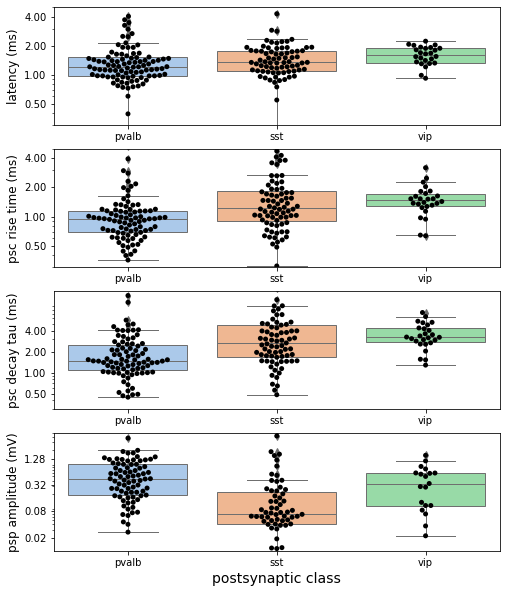

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

limits = {
    'latency': (0.3e-3, 5e-3),
    'psc_rise_time': (0.3e-3, 5e-3),
    'psc_decay_tau': (0.3e-3, 15e-3),
    'psp_amplitude': (10e-6, 5e-3),
}
units = ['ms', 'ms', 'ms', 'mV']
ticks = {
    'ms': 0.5e-3 * 2**np.arange(4),
    'mV': 20e-6 * 4**np.arange(4),
}

fig,ax = plt.subplots(len(limits), 1, figsize=(8, 2.5 * len(limits)))


for i, (field, lim) in enumerate(limits.items()):
    # box and swarm plots
    ax[i].set_yscale('log')
    ax[i].set_ylim(*lim)
    sns.boxplot(x="post_class", y=field, data=pairs, ax=ax[i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="post_class", y=field, data=pairs, ax=ax[i], size=5, color=(0, 0, 0, 0.5))
    
    # clean up labels / ticks
    if i == len(limits)-1:
        ax[i].set_xlabel('postsynaptic class', size=14)
    else:
        ax[i].set_xlabel('')
    ax[i].set_ylabel(field.replace('_', ' ') + ' (%s)'%units[i], size=12)
    ax[i].set_yticks(ticks[units[i]])
    ax[i].set_yticklabels(['%0.2f' % (x*1000) for x in ticks[units[i]]])
    ax[i].set_yticklabels([], minor=True)


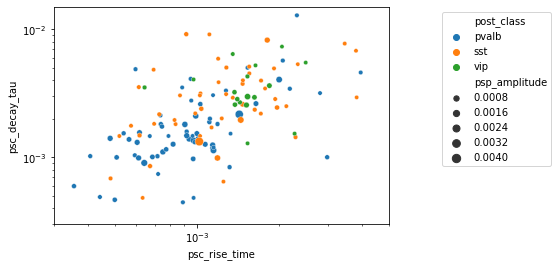

In [7]:
fig,ax = plt.subplots()

x_field = 'psc_rise_time'
y_field = 'psc_decay_tau'
ax.set_xlim(limits[x_field])
ax.set_ylim(limits[y_field])
ax.set_yscale('log')
ax.set_xscale('log')

sns.scatterplot(x=x_field, y=y_field, hue="post_class", size="psp_amplitude", data=pairs, ax=ax)
ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))